In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan  9 15:53:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P3    22W /  55W |      6MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd

2024-01-09 15:53:31.173193: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 15:53:31.174337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 15:53:31.200458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 15:53:31.201573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 15:53:31.763917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=250
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


## Instalación de Box2D

In [6]:
#!pip uninstall -y pybox2d

In [7]:
!pip install swig

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!git clone https://github.com/pybox2d/pybox2d

fatal: la ruta de destino 'pybox2d' ya existe y no es un directorio vacío.


In [9]:
!cd pybox2d && python setup.py build && python setup.py install

['Box2D', 'Box2D.examples', 'Box2D.tests', 'Box2D.b2', 'Box2D.examples.opencv', 'Box2D.examples.simple', 'Box2D.examples.pgu', 'Box2D.examples.backends', 'Box2D.examples.pgu.gui']
running build
running build_py
running build_ext
copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-311/Box2D
running egg_info
writing library/Box2D.egg-info/PKG-INFO
writing dependency_links to library/Box2D.egg-info/dependency_links.txt
writing top-level names to library/Box2D.egg-info/top_level.txt
reading manifest file 'library/Box2D.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'library/Box2D.egg-info/SOURCES.txt'
/home/usuario/anaconda3/lib/python3.11/site-packages/setuptools/command/build_py.py:201: _Warning: Package 'Box2D.examples.data.themes.default' is absent from the `packages` configuration.
!!

        ********************************************************************************
        ######################

In [10]:
pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [12]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a,s',r] reales o sintéticas, de longitud 2*ob_space.shape[0] + ac_space.n+1.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 10)          220       
                                                                 
 layer2 (Dense)              (None, None, 10)          110       
                                                                 
 layer3 (Dense)              (None, None, 10)          110       
                                                                 
 prob (Dense)                (None, None, 1)           11        
                                                                 
Total params: 451 (1.76 KB)
Trainable params: 451 (1.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-09 15:53:38.822962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-09 15:53:38.823014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-01-09 15:53:38.823017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-01-09 15:53:38.823135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-01-09 15:53:38.823149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-01-09 15:53:38.823152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [13]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [14]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, expert_s_prima, expert_r, agent_s, agent_a, agent_s_prima, agent_r):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net

        # -Experto: [s,a,s',r]
        self.expert_s=expert_s
        self.expert_a=expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)


        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)
        expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, expert_r], axis=1)

        # -Agente:  [s,a,s',r]
        self.agent_s=agent_s
        self.agent_a=agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)

        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a_s_r)

        #-Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [15]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation=tf.tanh,name='layer1'),
        layers.Dense(units=6, activation=tf.tanh, name='layer2'),
        layers.Dense(units=4, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           54        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 4)           28        
                                                                 
 layer4 (Dense)              (None, None, 4)           20        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           54        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 1)           7         
                                                                 
Total params: 103 (412.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [17]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [18]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env=env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    # Devuelve los parámetros \theta de la política \pi
    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] sinteticos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0


        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0

            truncated=False
            terminated=False


            # La primera acción de cada episodio se crea con la red neuronal
            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            truncated=False
            terminated=False

            # Tenemos una política entrenada
            Policy = Policy_net('policy',env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_1,s_2,s_3,...,s_8]] por eso su tamaño es (1,8)
                observations.append(next_obs)  # S_i-1

                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                if success_num >= 100:
                    break
            else:
                success_num = 0


        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        next_observations = np.reshape(next_observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        # Devolvemos la secuencia (S,A,S',R) junto con la política anterior y la actual política,
        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [19]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [20]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen1=np.concatenate([generate_observations,generate_a_one_hot],axis=1)

        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)

        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):

        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        if generate_next_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        else:
           generate_next_observations_new= np.resize(generate_next_observations, generate_observations.shape)
           dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations_new], axis=1)

        rewards=np.array(rewards).reshape(-1,1)

        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento 
        #if len(dataset_gen) >= BATCH_SIZE: 
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices[0]]


        # 3) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento y las combinamos
        dataset_gen=dataset_gen.reshape(1,-1)
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat( [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0 )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )



        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations) #       generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

         ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)


        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}



# Experimentación de GAIL con LunarLander

## Experimento 1

### Construcción de base de datos experta con 1 trayectoria 

In [21]:
!ls

actions_LunarLander.csv		    observations_LunarLander.csv
ExtendedGAIL_LunarLander_Ene.ipynb  pybox2d
next_observations_LunarLander.csv   rewards_LunarLander.csv
n_trayectoria_LunarLander.csv


In [22]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [23]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [24]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [25]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [26]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [27]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [28]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [29]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [30]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


437/437 [==============================] - 8889s 20s/step - d_loss: 1.9671 - g_loss: 2.3762


### Evaluación de GAIL

In [31]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 1.3978e-04 - accuracy: 0.0000e+00
>Loss real: 
0.0022365564946085215
>Loss fake: 
0.0001397844316670671


Episode  0 Total reward: -149.66416306109048
Episode  1 Total reward: 18.385961038347503
Episode  2 Total reward: -389.92024590150584
Episode  3 Total reward: -113.91531598764053
Episode  4 Total reward: -97.49785712883805
Episode  5 Total reward: -510.5581226911536
Episode  6 Total reward: -7.238372694377915
Episode  7 Total reward: 19.73134609721913
Episode  8 Total reward: -343.10557061682437
Episode  9 Total reward: -451.89299970762056
Episode  10 Total reward: -217.21660671958358
Episode  11 Total reward: -157.96347149918455
Episode  12 Total reward: -82.78351877634876
Episode  13 Total reward: -268.6666597438704
Episode  14 Total reward: -408.02187756440964
Episode  15 Total reward: -132.82790937891605
Episode  16 Total reward: -91.72892730189623
Episode  17 Total reward: -101.44449850289885
Episode  18 Total reward: -341.07383651699206
Episode  19 Total reward: -107.6756983189188
Episode  20 Total reward: -84.97172447228746
Episode  21 Total reward: -107.34660234693875
Episode  

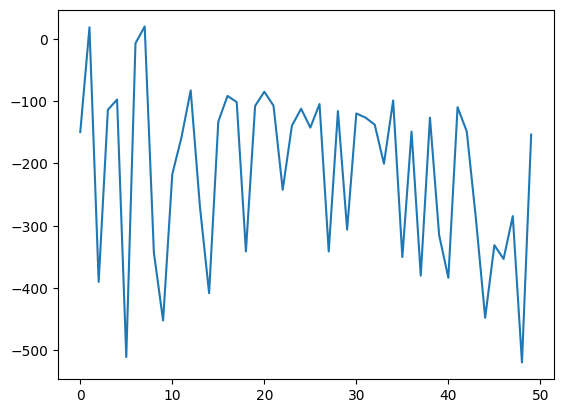


Recompensa de Media: -213.1156964379952 



In [32]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

### Construcción de base de datos experta con 2 trayectoria 

In [33]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [34]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [35]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [36]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [37]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [38]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [39]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [40]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [41]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


301/301 [==============================] - 6138s 20s/step - d_loss: 1.9079 - g_loss: 2.5855


### Evaluación de GAIL

In [42]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 3.8833e-08 - accuracy: 0.0000e+00
>Loss real: 
0.00014605277101509273
>Loss fake: 
3.88333347700609e-08


Episode  0 Total reward: -93.14831119280068
Episode  1 Total reward: -106.72858936330188
Episode  2 Total reward: -278.84813655436324
Episode  3 Total reward: -255.29521242994235
Episode  4 Total reward: -75.47627626906383
Episode  5 Total reward: -119.28690319512665
Episode  6 Total reward: -109.23092798355069
Episode  7 Total reward: -110.9286849688606
Episode  8 Total reward: -58.270122836605765
Episode  9 Total reward: -117.309109947489
Episode  10 Total reward: -80.9860113358867
Episode  11 Total reward: -161.93563639768638
Episode  12 Total reward: -92.11677934432885
Episode  13 Total reward: -101.17197152901662
Episode  14 Total reward: -72.56531255707628
Episode  15 Total reward: -188.74928800652077
Episode  16 Total reward: -238.25874973628675
Episode  17 Total reward: -102.99442119134076
Episode  18 Total reward: -352.5779216579115
Episode  19 Total reward: -262.22273989025075
Episode  20 Total reward: -52.00719866022561
Episode  21 Total reward: -194.08815984150453
Episode  

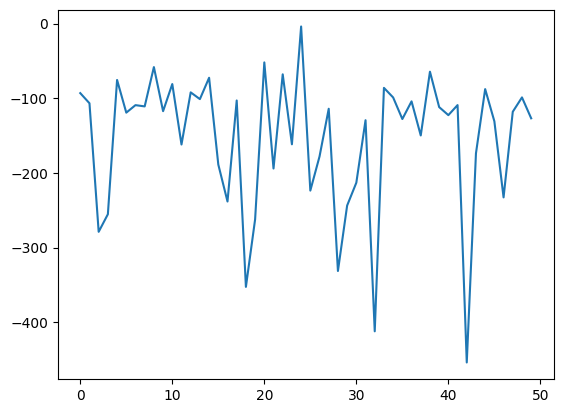


Recompensa de Media: -154.0142269627096 



In [43]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

### Construcción de base de datos experta con 3 trayectoria 

In [44]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [45]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [46]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [47]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [48]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [49]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [50]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [51]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [52]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


315/315 [==============================] - 6548s 21s/step - d_loss: 1.9054 - g_loss: 2.8731


### Evaluación de GAIL

In [53]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
6.038071092007158e-07
>Loss fake: 
0.0


Episode  0 Total reward: -99.49196237078696
Episode  1 Total reward: -141.90001428620803
Episode  2 Total reward: -116.72304302887149
Episode  3 Total reward: -79.14846765259153
Episode  4 Total reward: -111.6250167888399
Episode  5 Total reward: -131.78966992766175
Episode  6 Total reward: -93.75999555535829
Episode  7 Total reward: -208.76982604151874
Episode  8 Total reward: -226.91689188379414
Episode  9 Total reward: -19.161670572131783
Episode  10 Total reward: -108.99843470561152
Episode  11 Total reward: -220.15802979689505
Episode  12 Total reward: -151.64348858841493
Episode  13 Total reward: -184.95484107208765
Episode  14 Total reward: -169.35731499658203
Episode  15 Total reward: -78.0545078340712
Episode  16 Total reward: -91.79494942223545
Episode  17 Total reward: -146.1617804675975
Episode  18 Total reward: -287.4468186495753
Episode  19 Total reward: -156.5815138245521
Episode  20 Total reward: -397.51427751321205
Episode  21 Total reward: -258.69412679909544
Episode 

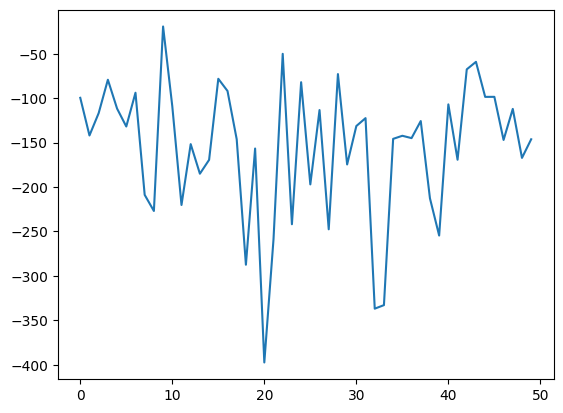


Recompensa de Media: -155.60526099413588 



In [54]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

### Construcción de base de datos experta con 4 trayectoria 

In [55]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [56]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [57]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [58]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [59]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [60]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [61]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [62]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [63]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


289/289 [==============================] - 5913s 20s/step - d_loss: 1.8978 - g_loss: 2.2194


### Evaluación de GAIL

In [64]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.2223074108419496e-08
>Loss fake: 
0.0


Episode  0 Total reward: -23.93869441759371
Episode  1 Total reward: -359.04934663205916
Episode  2 Total reward: -197.57423393413342
Episode  3 Total reward: -222.23217185638103
Episode  4 Total reward: -97.5962207158627
Episode  5 Total reward: -108.76769570661469
Episode  6 Total reward: -107.76657273018517
Episode  7 Total reward: -8.616130933047216
Episode  8 Total reward: -226.32146743227534
Episode  9 Total reward: -162.27151189570034
Episode  10 Total reward: -402.8855811640126
Episode  11 Total reward: -115.8951341370431
Episode  12 Total reward: -260.90368177238815
Episode  13 Total reward: -135.7135130241795
Episode  14 Total reward: -392.20139310068726
Episode  15 Total reward: -143.07127167940874
Episode  16 Total reward: -137.38865707499633
Episode  17 Total reward: -171.09093475990073
Episode  18 Total reward: -93.17785313435007
Episode  19 Total reward: -62.15609865067675
Episode  20 Total reward: -141.24381275065113
Episode  21 Total reward: -160.03917685372315
Episode

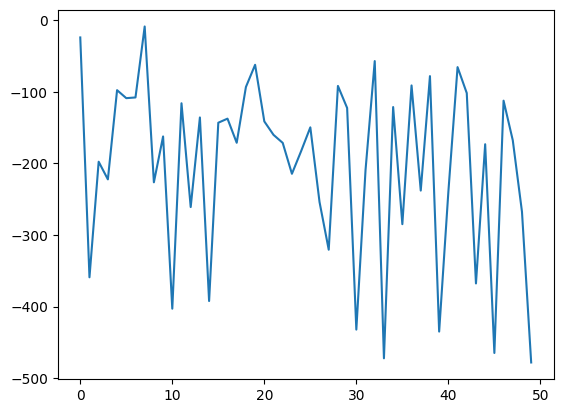


Recompensa de Media: -201.84726043578766 



In [65]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

### Construcción de base de datos experta con 2 trayectoria 

In [66]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [67]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [68]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [69]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [70]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [71]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [72]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [73]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [74]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


316/316 [==============================] - 6472s 20s/step - d_loss: 1.9002 - g_loss: 2.4204


### Evaluación de GAIL

In [75]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
2.8293349885188945e-09
>Loss fake: 
0.0


Episode  0 Total reward: -171.423767033876
Episode  1 Total reward: -228.53443927161845
Episode  2 Total reward: -333.0128657510836
Episode  3 Total reward: -77.18597437612044
Episode  4 Total reward: -151.7730637524791
Episode  5 Total reward: -109.75458357519962
Episode  6 Total reward: -111.73552535366375
Episode  7 Total reward: -106.44103221223385
Episode  8 Total reward: -101.77824990473407
Episode  9 Total reward: -206.23835078000735
Episode  10 Total reward: -147.5329603014613
Episode  11 Total reward: -418.3755946097829
Episode  12 Total reward: -414.53031962779903
Episode  13 Total reward: -275.95114021424024
Episode  14 Total reward: -167.65446806185423
Episode  15 Total reward: -150.1072373756763
Episode  16 Total reward: -255.43534876323793
Episode  17 Total reward: -165.32198542186194
Episode  18 Total reward: -287.63512480998827
Episode  19 Total reward: -265.8927006405074
Episode  20 Total reward: -126.80617660134689
Episode  21 Total reward: -101.29724928152001
Episode

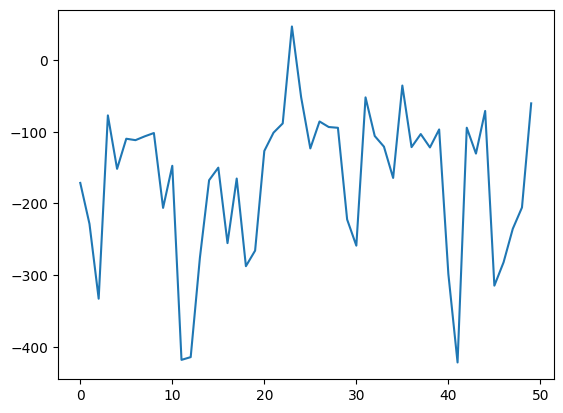


Recompensa de Media: -167.6623689506118 



In [76]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

### Construcción de base de datos experta con 6 trayectoria 

In [77]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [78]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [79]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [80]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [81]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [82]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [83]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [84]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [85]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


303/303 [==============================] - 6204s 20s/step - d_loss: 1.9006 - g_loss: 3.3962


### Evaluación de GAIL

In [86]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
0.0
>Loss fake: 
0.0


Episode  0 Total reward: -88.28110324262758
Episode  1 Total reward: -103.84420947308858
Episode  2 Total reward: -125.08746335297118
Episode  3 Total reward: -134.99404832687708
Episode  4 Total reward: -111.42092426938153
Episode  5 Total reward: -119.37321846320279
Episode  6 Total reward: -148.20238531462843
Episode  7 Total reward: -116.92023423775936
Episode  8 Total reward: -213.2973271736064
Episode  9 Total reward: -182.52343906452904
Episode  10 Total reward: -192.2273426224919
Episode  11 Total reward: -192.34554996316632
Episode  12 Total reward: -115.42545567152771
Episode  13 Total reward: -68.62195971837833
Episode  14 Total reward: -145.846167371545
Episode  15 Total reward: -418.8727014765741
Episode  16 Total reward: -230.5230067915688
Episode  17 Total reward: -63.83506650496166
Episode  18 Total reward: -208.39315323858528
Episode  19 Total reward: -142.39494434429116
Episode  20 Total reward: -228.3250178210822
Episode  21 Total reward: -331.87801601043793
Episode 

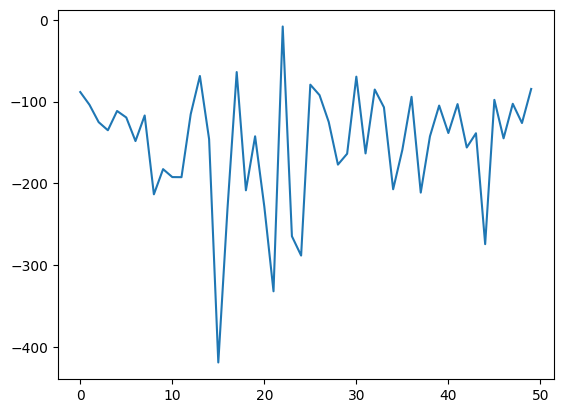


Recompensa de Media: -151.80167921000685 



In [87]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

### Construcción de base de datos experta con 7 trayectoria 

In [88]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [89]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [90]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [91]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [92]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [93]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [94]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [95]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [96]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


312/312 [==============================] - 6402s 21s/step - d_loss: 1.8992 - g_loss: 2.3110


### Evaluación de GAIL

In [97]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
0.0
>Loss fake: 
0.0


Episode  0 Total reward: -101.16621429205497
Episode  1 Total reward: -305.80839133704126
Episode  2 Total reward: -136.18559613805542
Episode  3 Total reward: -276.6688128900634
Episode  4 Total reward: -298.2261301679698
Episode  5 Total reward: -369.04527291040836
Episode  6 Total reward: -169.67952046927724
Episode  7 Total reward: -202.83542474262057
Episode  8 Total reward: -368.0957920894822
Episode  9 Total reward: -108.76104611020224
Episode  10 Total reward: -185.23177030913138
Episode  11 Total reward: -108.53277683537354
Episode  12 Total reward: -132.15224127557212
Episode  13 Total reward: -124.73710973163463
Episode  14 Total reward: -131.22914049605976
Episode  15 Total reward: -132.56063878030884
Episode  16 Total reward: -201.89921275077205
Episode  17 Total reward: -210.15758582096936
Episode  18 Total reward: -134.48523798573282
Episode  19 Total reward: -137.54586123333462
Episode  20 Total reward: -242.09303336001386
Episode  21 Total reward: -173.37483891193148
E

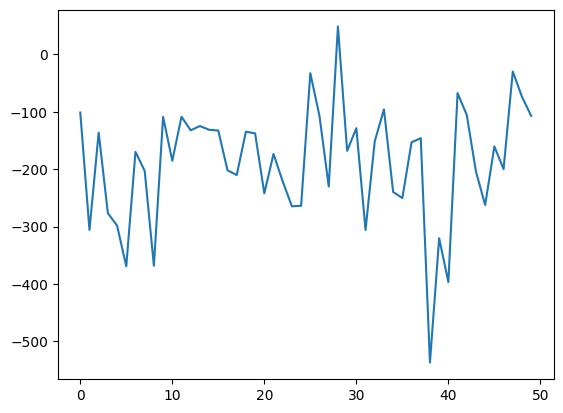


Recompensa de Media: -188.46481197646182 



In [98]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

### Construcción de base de datos experta con 8 trayectoria 

In [99]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [100]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [101]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [102]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [103]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [104]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [105]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [106]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [107]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


304/304 [==============================] - 6251s 21s/step - d_loss: 1.8975 - g_loss: 2.8720


### Evaluación de GAIL

In [108]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
0.0
>Loss fake: 
0.0


Episode  0 Total reward: -230.1161349436301
Episode  1 Total reward: -117.37298032811974
Episode  2 Total reward: -129.67266357459437
Episode  3 Total reward: -230.70677602400974
Episode  4 Total reward: -139.92302366852203
Episode  5 Total reward: -110.84839017977252
Episode  6 Total reward: -133.59834769323095
Episode  7 Total reward: -203.1982855644315
Episode  8 Total reward: -90.03100780543562
Episode  9 Total reward: -157.50532433505987
Episode  10 Total reward: -124.30561413294657
Episode  11 Total reward: -81.33492308677106
Episode  12 Total reward: -187.9081788587036
Episode  13 Total reward: -103.4829873058678
Episode  14 Total reward: -124.55920357752944
Episode  15 Total reward: -111.68453387576105
Episode  16 Total reward: -242.99232323472378
Episode  17 Total reward: -285.93331197910373
Episode  18 Total reward: -129.32842669966308
Episode  19 Total reward: -224.93926249857807
Episode  20 Total reward: -190.7059019047528
Episode  21 Total reward: -104.6055997036372
Episod

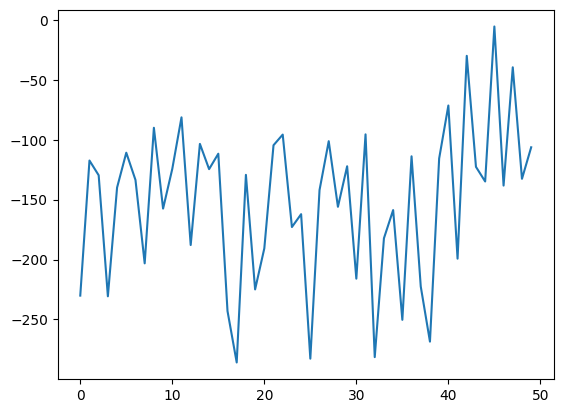


Recompensa de Media: -151.50151058380962 



In [109]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

### Construcción de base de datos experta con 9 trayectoria 

In [110]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [111]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [112]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [113]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [114]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [115]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [116]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [117]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [118]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


310/310 [==============================] - 6430s 21s/step - d_loss: 1.9006 - g_loss: 2.3335


### Evaluación de GAIL

In [119]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
0.0
>Loss fake: 
0.0


Episode  0 Total reward: -306.36375188909176
Episode  1 Total reward: -258.8947114661341
Episode  2 Total reward: -351.6150902107332
Episode  3 Total reward: -182.39331468021442
Episode  4 Total reward: -78.40464897268545
Episode  5 Total reward: -121.40299104049953
Episode  6 Total reward: -230.70908230871055
Episode  7 Total reward: -314.4433423552421
Episode  8 Total reward: -148.546978292681
Episode  9 Total reward: -301.6177013260552
Episode  10 Total reward: -186.35790415032326
Episode  11 Total reward: -489.83607398696523
Episode  12 Total reward: -291.879497476012
Episode  13 Total reward: -76.2381076220236
Episode  14 Total reward: -54.14226842208534
Episode  15 Total reward: -250.30889393869
Episode  16 Total reward: -9.077299880558272
Episode  17 Total reward: -202.35598874976347
Episode  18 Total reward: -132.23878270184997
Episode  19 Total reward: -94.60510317345668
Episode  20 Total reward: -232.80038287770122
Episode  21 Total reward: -123.27922921135188
Episode  22 Tot

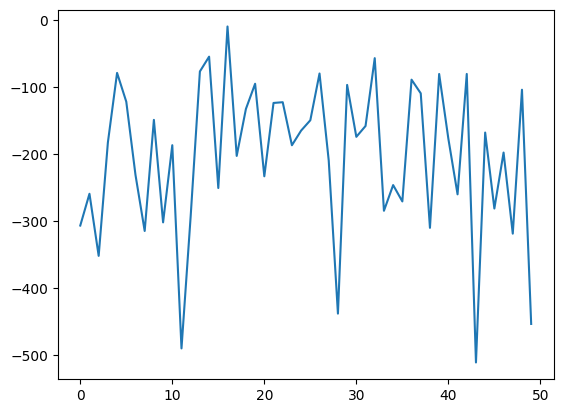


Recompensa de Media: -204.13011500796463 



In [120]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

### Construcción de base de datos experta con 10 trayectoria 

In [121]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_LunarLander.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]

	 Estados siguientes: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]

	 Recompensas: [   0    0   

In [122]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [123]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [124]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [125]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [126]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [127]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [128]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [129]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


297/297 [==============================] - 6378s 21s/step - d_loss: 1.8925 - g_loss: 1.9388


### Evaluación de GAIL

In [130]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
0.0
>Loss fake: 
0.0


Episode  0 Total reward: -96.60530979103294
Episode  1 Total reward: -322.72626856095565
Episode  2 Total reward: -207.49585738247885
Episode  3 Total reward: -113.93612730227393
Episode  4 Total reward: -116.19026047853303
Episode  5 Total reward: -197.8051587952449
Episode  6 Total reward: -116.62362740529855
Episode  7 Total reward: -317.9933518542166
Episode  8 Total reward: -171.20528284453897
Episode  9 Total reward: -134.05440984737936
Episode  10 Total reward: -117.6586701972669
Episode  11 Total reward: -143.4317097301528
Episode  12 Total reward: -146.37356671683557
Episode  13 Total reward: -125.20059286613869
Episode  14 Total reward: -156.19924392151825
Episode  15 Total reward: -69.91167260801974
Episode  16 Total reward: -74.57811474484491
Episode  17 Total reward: -125.9218161311873
Episode  18 Total reward: -115.84439131591272
Episode  19 Total reward: -73.19731594409244
Episode  20 Total reward: -86.16123771276817
Episode  21 Total reward: -113.61847842579661
Episode 

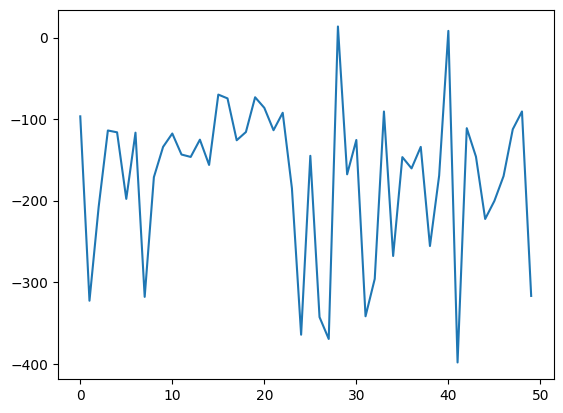


Recompensa de Media: -170.8683403522486 



In [131]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')